<a href="https://colab.research.google.com/github/IbrahimAllMamun/flood_incidence/blob/main/flood_incidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Data

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics, Input, Model
from tensorflow.keras.activations import gelu

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Random state initialization
RANDOM_STATE = 21
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

In [2]:
!wget https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv

--2025-10-02 20:48:59--  https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071590 (2.0M) [text/plain]
Saving to: ‘flood.csv’

flood.csv           100%[===================>]   1.98M  --.-KB/s    in 0.06s   

2025-10-02 20:48:59 (33.8 MB/s) - ‘flood.csv’ saved [2071590/2071590]



In [3]:
df = pd.read_csv('flood.csv')
df.rename(columns={'Flood?':'Flood'}, inplace=True)
df = df.sort_values(["Year", "Month", "Station_Number"])
# df.drop(columns=['Sl', 'LATITUDE', 'LONGITUDE', 'Period'], inplace=True)
df.fillna({'Flood':0}, inplace=True)
display(df.head())

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood
5892,5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,25.63,88.66,37,1948.01,0.0
1356,1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,24.88,89.36,20,1948.01,0.0
13188,13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,24.75,90.41,19,1948.01,0.0
18288,18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,24.29,91.73,23,1948.01,0.0
6684,6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,23.61,89.84,9,1948.01,0.0


In [4]:
df.shape

(20544, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20544 entries, 5892 to 20543
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sl                 20544 non-null  int64  
 1   Station_Names      20544 non-null  object 
 2   Year               20544 non-null  int64  
 3   Month              20544 non-null  int64  
 4   Max_Temp           20544 non-null  float64
 5   Min_Temp           20544 non-null  float64
 6   Rainfall           20544 non-null  float64
 7   Relative_Humidity  20544 non-null  float64
 8   Wind_Speed         20544 non-null  float64
 9   Cloud_Coverage     20544 non-null  float64
 10  Bright_Sunshine    20544 non-null  float64
 11  Station_Number     20544 non-null  int64  
 12  X_COR              20544 non-null  float64
 13  Y_COR              20544 non-null  float64
 14  LATITUDE           20544 non-null  float64
 15  LONGITUDE          20544 non-null  float64
 16  ALT                20544

# Data cleaning and sequence building

In [6]:
df["Month_sin"] = np.sin(2 * np.pi * (df["Month"] - 1) / 12.0)
df["Month_cos"] = np.cos(2 * np.pi * (df["Month"] - 1) / 12.0)


df["Max_Temp"] = df["Max_Temp"] + 273
df["Min_Temp"] = df["Min_Temp"] + 273

In [7]:
time_varying = [
    "Max_Temp", "Min_Temp", "Rainfall", "Relative_Humidity",
    "Wind_Speed", "Cloud_Coverage", "Bright_Sunshine",
    "Month_sin", "Month_cos"
]
static_feats = ["ALT", "X_COR", "Y_COR"]

In [8]:
def build_sequences_monthly(df, window=12):
    X_seq, X_static, y, groups = [], [], [], []

    for st, g in df.groupby("Station_Number"):
        g = g.sort_values(["Year", "Month"])   # continuous timeline per station

        seq_data = g[time_varying].to_numpy(dtype=float)
        static_vals = g[static_feats].iloc[0].to_numpy(dtype=float)
        labels = g["Flood"].to_numpy(dtype=int)
        years = g["Year"].to_numpy()
        months = g["Month"].to_numpy()

        for i in range(len(g) - window):
            X_seq.append(seq_data[i:i+window])
            X_static.append(static_vals)
            y.append(labels[i+window])  # predict flood in next month
            groups.append((st, years[i+window], months[i+window]))

    return (
        np.array(X_seq),
        np.array(X_static),
        np.array(y).astype(int),
        pd.DataFrame(groups, columns=["Station_Number", "Year", "Month"])
    )


# Example
X_seq, X_static, y, groups = build_sequences_monthly(df, window=24)
print("Sequences:", X_seq.shape)   # (N, 12, n_features)
print("Static:", X_static.shape)   # (N, 3)
print("Labels:", y.shape)          # (N,)
print("Positives:", y.sum(), "Negatives:", (y==0).sum())

Sequences: (19752, 24, 9)
Static: (19752, 3)
Labels: (19752,)
Positives: 3959 Negatives: 15793


In [9]:
groups

,Station_Number,Year,Month
0,41859,1956,1
1,41859,1956,2
2,41859,1956,3
3,41859,1956,4
4,41859,1956,5
...,...,...,...
19747,41998,2013,8
19748,41998,2013,9
19749,41998,2013,10
19750,41998,2013,11


## Data splitting

In [10]:
def scale_data(X_seq, X_sta):
    Ntr, T, F = X_seq.shape

    seq_scaler = StandardScaler()
    sta_scaler = StandardScaler()

    Xseq = seq_scaler.fit_transform(X_seq.reshape(-1, F)).reshape(Ntr, T, F)
    Xsta  = sta_scaler.fit_transform(X_sta)

    return Xseq, Xsta

# Build sequences first
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)

X_seq, X_static = scale_data(X_seq, X_static)

# Choose cutoff year
cutoff_year_val = 1993
cutoff_year_test = 2002

train_idx = groups["Year"] <= cutoff_year_val
val_idx = (groups["Year"] > cutoff_year_val) & (groups["Year"] < cutoff_year_test)

ftrain_idx = groups["Year"] <= cutoff_year_test
test_idx  = groups["Year"] > cutoff_year_test


fXseq_tr_s,     Xseq_tr_s,     Xseq_val_s,  Xseq_te_s   = X_seq[ftrain_idx],    X_seq[train_idx],     X_seq[val_idx] ,    X_seq[test_idx]
fXs_tr_s,       Xs_tr_s,       Xs_val_s,    Xs_te_s     = X_static[ftrain_idx], X_static[train_idx],  X_static[val_idx] , X_static[test_idx]
fy_train,       y_train,       y_val ,      y_test      = y[ftrain_idx],        y[train_idx],         y[val_idx] ,        y[test_idx]
fgroups_train,  groups_train,  groups_val,  groups_test = groups[ftrain_idx],   groups[train_idx],    groups[val_idx] ,   groups[test_idx]

print("Train:", Xseq_tr_s.shape, "Positives:", y_train.sum())
print("Validation :", Xseq_val_s.shape, "Positives:", y_val.sum())

print("Final Training :", fXseq_tr_s.shape, "Positives:", fy_train.sum())
print("Test :", Xseq_te_s.shape, "Positives:", y_test.sum())

Train: (12432, 12, 9) Positives: 2416
Validation : (3072, 12, 9) Positives: 635
Final Training : (15888, 12, 9) Positives: 3144
Test : (4260, 12, 9) Positives: 904


In [11]:
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", Xseq_tr_s.shape)   # (N, 12, n_features)
print("Static:", Xs_tr_s.shape)   # (N, 3)

Sequences: (12432, 12, 9)
Static: (12432, 3)


In [12]:
print(Xseq_val_s.shape[0]/(Xseq_tr_s.shape[0]+Xseq_val_s.shape[0]))
print(Xseq_te_s.shape[0]/(fXseq_tr_s.shape[0]+Xseq_te_s.shape[0]))

0.19814241486068113
0.2114353782013103


# Model Building

## make_model() function

In [13]:
def make_model(n_steps, n_seq_feats, n_static_feats, lstm_units=(64, 32), dense_units=32, dropout=0.2, lr=1e-3, threshold=0.5):
    initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
    prelu_initializer = tf.keras.initializers.he_normal(seed=RANDOM_STATE)


    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in

    # GRU stack
    x = layers.GRU(lstm_units[0], return_sequences=True, dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="GRU_1")(x)
    x = layers.GRU(lstm_units[1], dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="GRU_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_1")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_1")(x)
    x = layers.Dropout(dropout, name="Dropout_1")(x)

    inputs = [seq_in]

    sta_in = Input(shape=(n_static_feats,), name="static_in")
    s = layers.Dense(32, kernel_initializer=initializer, name="Static_Dense_1")(sta_in)
    s = layers.PReLU(alpha_initializer=prelu_initializer, name="Static_PReLU_1")(s)
    s = layers.Dropout(dropout, name="Static_Dropout_1")(s)
    x = layers.Concatenate()([x, s])
    inputs.append(sta_in)

    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_2")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_2")(x)
    x = layers.Dropout(dropout, name="Dropout_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_3")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_3")(x)
    x = layers.Dropout(dropout, name="Dropout_3")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model_GRU = Model(inputs=inputs, outputs=out, name="GRU")
    model_GRU.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        # optimizer=optimizers.RMSprop(learning_rate=lr, rho=0.9),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=threshold)
        ],
    )



    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in

    # LSTM stack
    x = layers.LSTM(lstm_units[0], return_sequences=True, dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="LSTM_1")(x)
    x = layers.LSTM(lstm_units[1], dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="LSTM_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_1")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_1")(x)
    x = layers.Dropout(dropout, name="Dropout_1")(x)

    inputs = [seq_in]


    x = layers.Concatenate()([x, s])
    inputs.append(sta_in)

    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_2")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_2")(x)
    x = layers.Dropout(dropout, name="Dropout_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_3")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_3")(x)
    x = layers.Dropout(dropout, name="Dropout_3")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model_LSTM = Model(inputs=inputs, outputs=out, name="LSTM")
    model_LSTM.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        # optimizer=optimizers.RMSprop(learning_rate=lr, rho=0.9),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=threshold)
        ],
    )

    return model_GRU, model_LSTM

## Model call

In [14]:
Ntr, T, F = Xseq_tr_s.shape
model_GRU, model_LSTM = make_model(
              n_steps=T,
              n_seq_feats=F,
              n_static_feats=Xs_tr_s.shape[1],
              lstm_units=(128, 64),
              dense_units=64,
              dropout=0.3,
              lr=1e-3,
              threshold=0.5
            )

model_GRU.summary()
model_LSTM.summary()

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_1 (GRU)         │ (None, 12, 128)   │     53,376 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_2 (GRU)         │ (None, 64)        │     37,248 │ GRU_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 64)        │      4,160 │ GRU_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dense_1      │ (None, 32)        │        128 │ static_in[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_1 (PReLU)     │ (None, 64)        │         64 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_PReLU_1      │ (None, 32)        │         32 │ Static_Dense_1[0… │
│ (PReLU)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 64)        │          0 │ PReLU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dropout_1    │ (None, 32)        │          0 │ Static_PReLU_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ Dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ Static_Dropout_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_2 (PReLU)     │ (None, 64)        │         64 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 64)        │          0 │ PReLU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_3 (Dense)     │ (None, 64)        │      4,160 │ Dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_3 (PReLU)     │ (None, 64)        │         64 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 64)        │          0 │ PReLU_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ Dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,569 (412.38 KB)

 Trainable params: 105,569 (412.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 12, 128)   │     70,656 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, 64)        │     49,408 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 64)        │      4,160 │ LSTM_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dense_1      │ (None, 32)        │        128 │ static_in[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_1 (PReLU)     │ (None, 64)        │         64 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_PReLU_1      │ (None, 32)        │         32 │ Static_Dense_1[0… │
│ (PReLU)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 64)        │          0 │ PReLU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dropout_1    │ (None, 32)        │          0 │ Static_PReLU_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ Dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ Static_Dropout_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_2 (PReLU)     │ (None, 64)        │         64 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 64)        │          0 │ PReLU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_3 (Dense)     │ (None, 64)        │      4,160 │ Dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_3 (PReLU)     │ (None, 64)        │         64 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 64)        │          0 │ PReLU_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ Dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,009 (527.38 KB)

 Trainable params: 135,009 (527.38 KB)

 Non-trainable params: 0 (0.00 B)

## Training Models

In [15]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

es = callbacks.EarlyStopping(
    monitor="val_auc_pr", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

Class weights: {0: 1.0, 1: 4.145695364238411}


### GRU-RNN Validation

In [16]:
history_GRU = model_GRU.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=100,
    batch_size=64,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.7738 - auc_pr: 0.3941 - auc_roc: 0.7542 - loss: 0.4281 - precision: 0.4143 - recall: 0.3038 - val_accuracy: 0.8512 - val_auc_pr: 0.7346 - val_auc_roc: 0.9098 - val_loss: 0.3044 - val_precision: 0.6240 - val_recall: 0.7055
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8594 - auc_pr: 0.6470 - auc_roc: 0.9009 - loss: 0.2965 - precision: 0.6510 - recall: 0.5532 - val_accuracy: 0.8659 - val_auc_pr: 0.7557 - val_auc_roc: 0.9183 - val_loss: 0.2849 - val_precision: 0.6687 - val_recall: 0.6961
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8600 - auc_pr: 0.6629 - auc_roc: 0.9060 - loss: 0.2887 - precision: 0.6659 - recall: 0.5224 - val_accuracy: 0.8737 - val_auc_pr: 0.7621 - val_auc_roc: 0.9202 - val_loss: 0.2782 - val_precision: 0.7241 - val_recall: 0.6283
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8705 - auc_pr: 0.7039 - auc_roc: 0.9169 - loss: 0.2749 - pr

#### Threshold tuning on validation

In [17]:
val_probs = model_GRU.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)



96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Best threshold (F1 on val): 0.4431453


#### Final evaluation on test

In [18]:
from sklearn.metrics import accuracy_score


test_probs = model_GRU.predict([Xseq_val_s, Xs_val_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, test_probs))
print("PR-AUC:",  average_precision_score(y_val, test_probs))
print("Accuracy:", accuracy_score(y_val, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, test_pred))
print(classification_report(y_val, test_pred, digits=3))

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
ROC-AUC: 0.9289335345186898
PR-AUC: 0.7864177691329647
Accuracy: 0.8772786458333334
Confusion matrix:
 [[2227  210]
 [ 167  468]]
              precision    recall  f1-score   support

           0      0.930     0.914     0.922      2437
           1      0.690     0.737     0.713       635

    accuracy                          0.877      3072
   macro avg      0.810     0.825     0.817      3072
weighted avg      0.881     0.877     0.879      3072



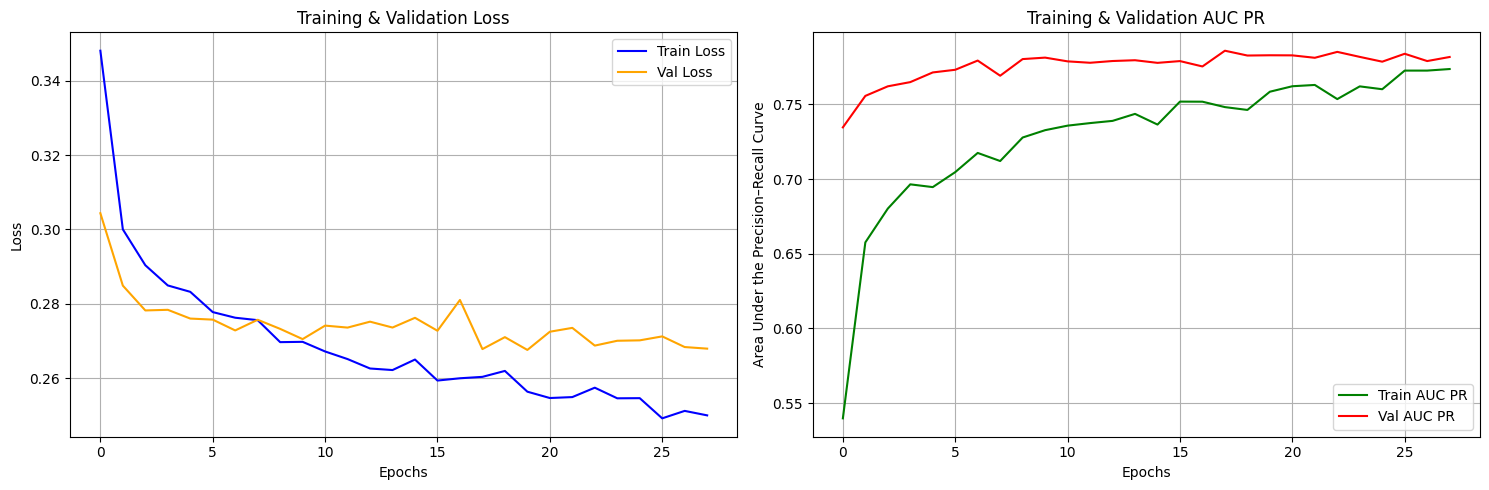

In [19]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --------- Loss subplot ---------
axs[0].plot(history_GRU.history["loss"], label="Train Loss", color='blue')
axs[0].plot(history_GRU.history["val_loss"], label="Val Loss", color='orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training & Validation Loss")
axs[0].legend()
axs[0].grid(True)

# --------- Accuracy subplot (if exists) ---------
axs[1].plot(history_GRU.history["auc_pr"], label="Train AUC PR", color='green')
axs[1].plot(history_GRU.history["val_auc_pr"], label="Val AUC PR", color='red')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Area Under the Precision–Recall Curve")
axs[1].set_title("Training & Validation AUC PR")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### LSTM-RNN Validation

In [20]:
history_LSTM = model_LSTM.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=100,
    batch_size=64,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.7976 - auc_pr: 0.4231 - auc_roc: 0.7691 - loss: 0.4083 - precision: 0.4600 - recall: 0.2746 - val_accuracy: 0.8675 - val_auc_pr: 0.7621 - val_auc_roc: 0.9214 - val_loss: 0.2830 - val_precision: 0.6652 - val_recall: 0.7228
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8718 - auc_pr: 0.6834 - auc_roc: 0.9129 - loss: 0.2822 - precision: 0.7019 - recall: 0.5588 - val_accuracy: 0.8675 - val_auc_pr: 0.7744 - val_auc_roc: 0.9256 - val_loss: 0.2808 - val_precision: 0.6624 - val_recall: 0.7323
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8795 - auc_pr: 0.7151 - auc_roc: 0.9173 - loss: 0.2750 - precision: 0.7227 - recall: 0.5895 - val_accuracy: 0.8701 - val_auc_pr: 0.7757 - val_auc_roc: 0.9262 - val_loss: 0.2785 - val_precision: 0.6720 - val_recall: 0.7260
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8778 - auc_pr: 0.7212 - auc_roc: 0.9214 - loss: 0.2682 - p

#### Threshold tuning on validation

In [21]:
val_probs = model_LSTM.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Best threshold (F1 on val): 0.4310136


#### Final evaluation on test

In [22]:
from sklearn.metrics import accuracy_score

test_probs = model_LSTM.predict([Xseq_val_s, Xs_val_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, test_probs))
print("PR-AUC:",  average_precision_score(y_val, test_probs))
print("Accuracy:", accuracy_score(y_val, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, test_pred))
print(classification_report(y_val, test_pred, digits=3))

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
ROC-AUC: 0.9320773249671243
PR-AUC: 0.7933178118475632
Accuracy: 0.87890625
Confusion matrix:
 [[2234  203]
 [ 169  466]]
              precision    recall  f1-score   support

           0      0.930     0.917     0.923      2437
           1      0.697     0.734     0.715       635

    accuracy                          0.879      3072
   macro avg      0.813     0.825     0.819      3072
weighted avg      0.881     0.879     0.880      3072



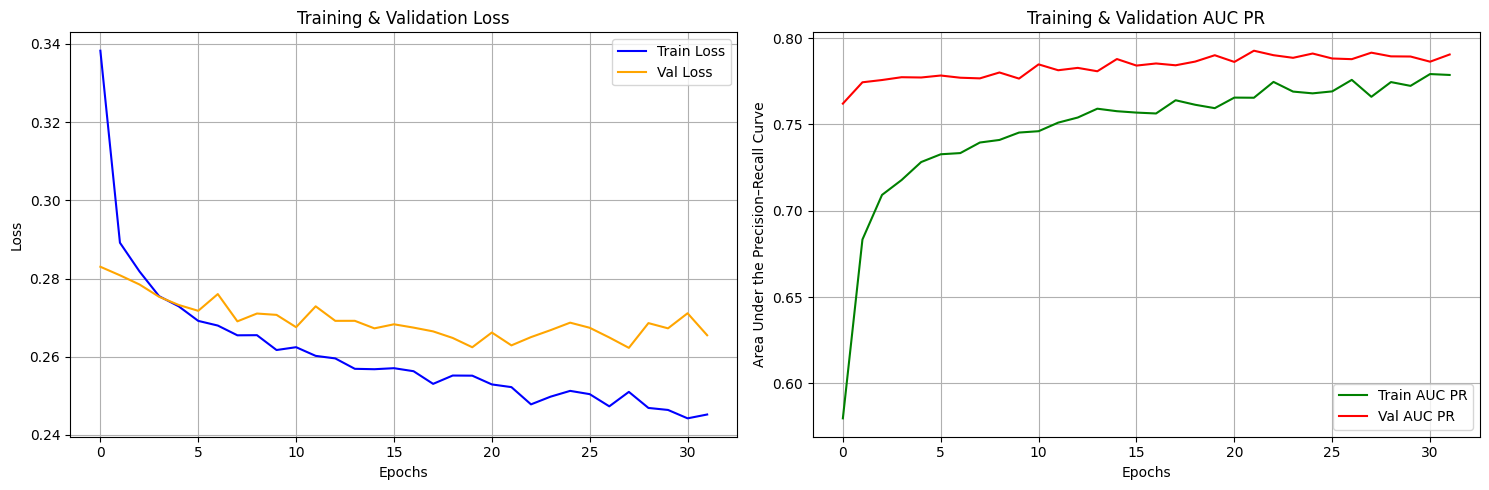

In [23]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --------- Loss subplot ---------
axs[0].plot(history_LSTM.history["loss"], label="Train Loss", color='blue')
axs[0].plot(history_LSTM.history["val_loss"], label="Val Loss", color='orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training & Validation Loss")
axs[0].legend()
axs[0].grid(True)

# --------- Accuracy subplot (if exists) ---------
axs[1].plot(history_LSTM.history["auc_pr"], label="Train AUC PR", color='green')
axs[1].plot(history_LSTM.history["val_auc_pr"], label="Val AUC PR", color='red')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Area Under the Precision–Recall Curve")
axs[1].set_title("Training & Validation AUC PR")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
LSTM ROC AUC = 0.9133
GRU  ROC AUC = 0.9104


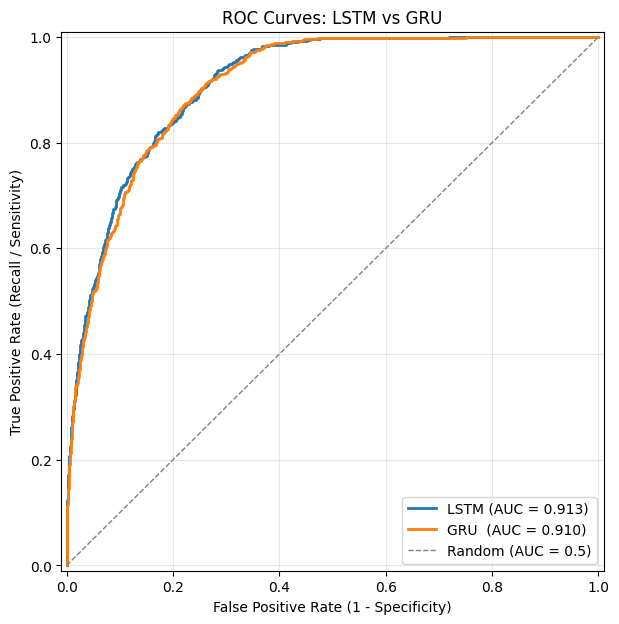

In [24]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1) Get predicted probabilities
y_prob_LSTM = model_LSTM.predict([Xseq_te_s, Xs_te_s]).ravel()
y_prob_GRU  = model_GRU.predict([Xseq_te_s, Xs_te_s]).ravel()

# 2) Compute ROC curve and AUC for both models
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_LSTM)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test, y_prob_GRU)
roc_auc_gru = auc(fpr_gru, tpr_gru)

print(f"LSTM ROC AUC = {roc_auc_lstm:.4f}")
print(f"GRU  ROC AUC = {roc_auc_gru:.4f}")

# 3) Plot both ROC curves
plt.figure(figsize=(7,7))
plt.plot(fpr_lstm, tpr_lstm, lw=2, label=f"LSTM (AUC = {roc_auc_lstm:.3f})")
plt.plot(fpr_gru,  tpr_gru,  lw=2, label=f"GRU  (AUC = {roc_auc_gru:.3f})")

# Reference line for random classifier
plt.plot([0,1], [0,1], color="gray", linestyle="--", lw=1, label="Random (AUC = 0.5)")

# Formatting
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curves: LSTM vs GRU")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# Model Visualisation

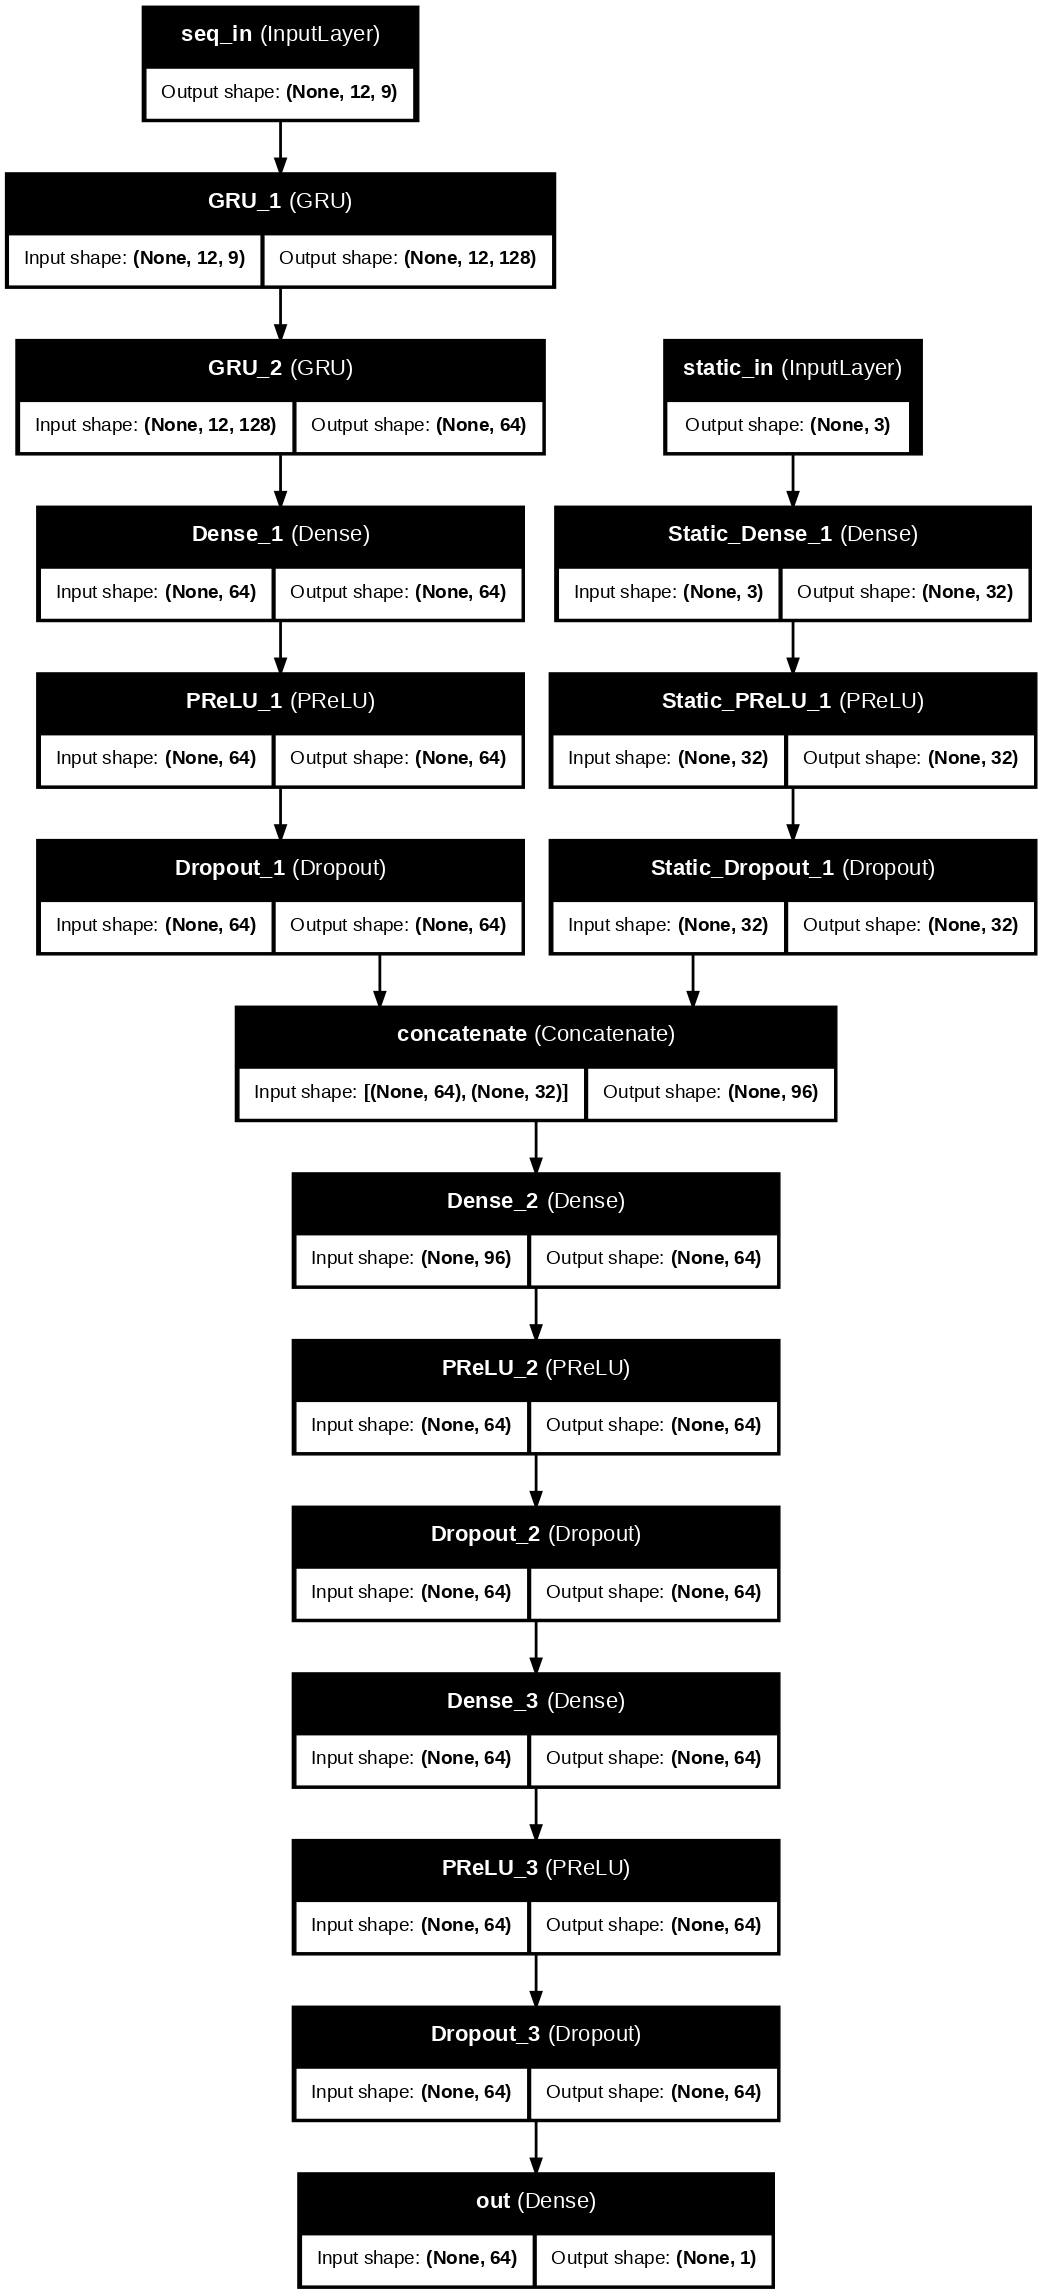

In [25]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(
    model_GRU,
    to_file="model_diagram.png",  # output file
    show_shapes=True,             # show tensor shapes
    show_layer_names=True,        # show layer names
    expand_nested=False,
    dpi=100
)

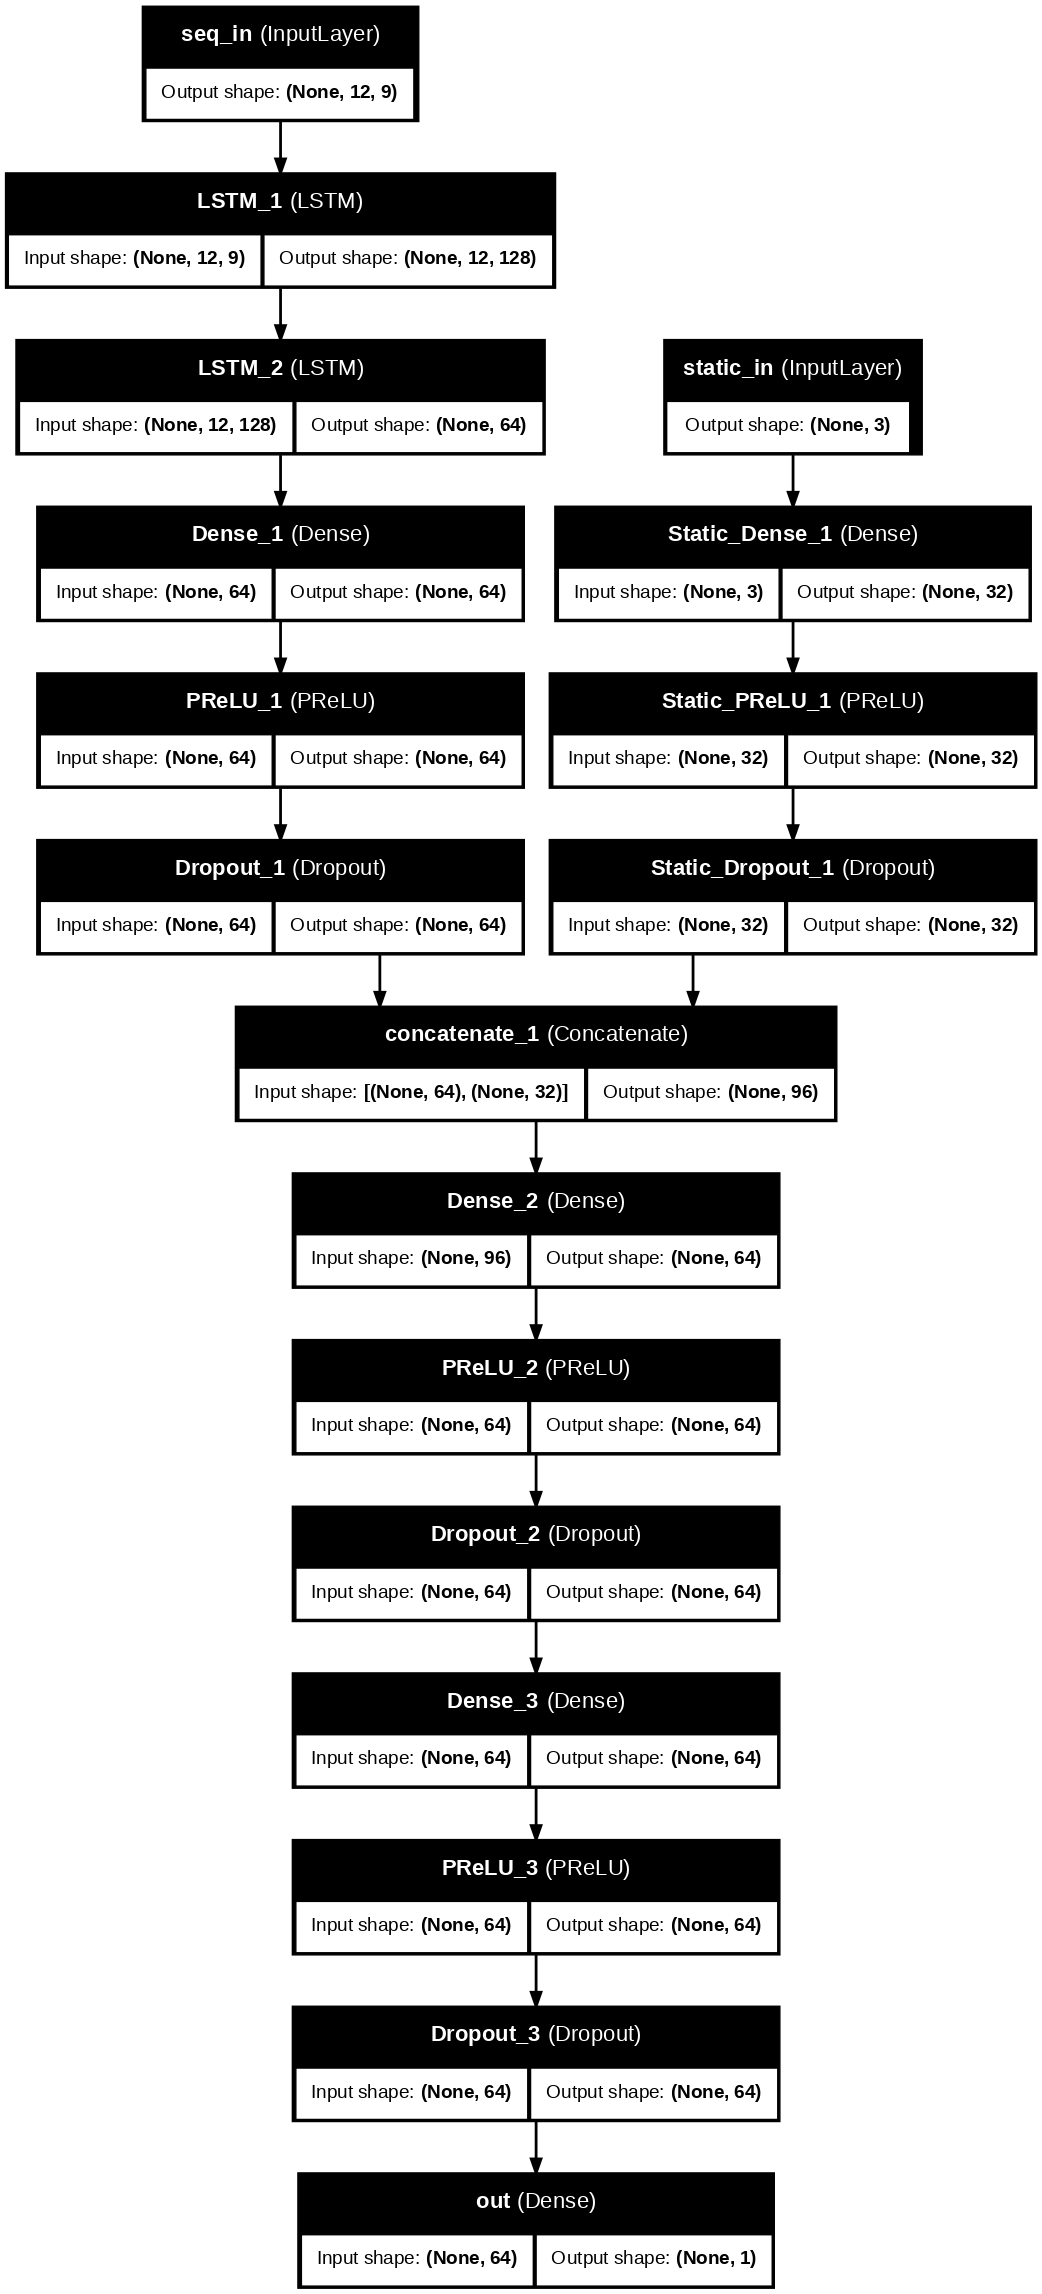

In [26]:
plot_model(
    model_LSTM,
    to_file="model_diagram.png",  # output file
    show_shapes=True,             # show tensor shapes
    show_layer_names=True,        # show layer names
    expand_nested=False,
    dpi=100
)

# Model Evaluation

In [27]:
Ntr, T, F = fXseq_tr_s.shape
model_GRU, model_LSTM = make_model(
              n_steps=T,
              n_seq_feats=F,
              n_static_feats=fXs_tr_s.shape[1],
              lstm_units=(128, 64),
              dense_units=64,
              dropout=0.3,
              lr=1e-3,
              threshold=0.5
            )

## Training Models

In [28]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

es = callbacks.EarlyStopping(
    monitor="val_auc_pr", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

Class weights: {0: 1.0, 1: 4.145695364238411}


### GRU-RNN Testing

In [29]:
history_GRU = model_GRU.fit(
    x=[fXseq_tr_s, fXs_tr_s],
    y=fy_train,
    validation_data=([Xseq_te_s, Xs_te_s], y_test),
    epochs=100,
    batch_size=64,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.8058 - auc_pr: 0.4750 - auc_roc: 0.8069 - loss: 0.3912 - precision: 0.5082 - recall: 0.3337 - val_accuracy: 0.8371 - val_auc_pr: 0.6764 - val_auc_roc: 0.8907 - val_loss: 0.3238 - val_precision: 0.6346 - val_recall: 0.5476
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8625 - auc_pr: 0.6671 - auc_roc: 0.9035 - loss: 0.2989 - precision: 0.6846 - recall: 0.5524 - val_accuracy: 0.8493 - val_auc_pr: 0.6987 - val_auc_roc: 0.8963 - val_loss: 0.3130 - val_precision: 0.7009 - val_recall: 0.5055
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8672 - auc_pr: 0.6983 - auc_roc: 0.9112 - loss: 0.2873 - precision: 0.7117 - recall: 0.5400 - val_accuracy: 0.8453 - val_auc_pr: 0.7108 - val_auc_roc: 0.9015 - val_loss: 0.3067 - val_precision: 0.6526 - val_recall: 0.5796
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8732 - auc_pr: 0.7095 - auc_roc: 0.9129 - loss: 0.2826 - p

#### Threshold tuning on validation

In [30]:
test_probs = model_GRU.predict([Xseq_te_s, Xs_te_s]).ravel()
prec, rec, thr = precision_recall_curve(y_test, test_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Best threshold (F1 on val): 0.3770425


#### Final evaluation on test

In [31]:
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("F1-Score:\n", f1)
print(classification_report(y_test, test_pred, digits=3))

ROC-AUC: 0.9128934308648096
PR-AUC: 0.7347787185710087
Accuracy: 0.8518779342723005
Confusion matrix:
 [[2994  362]
 [ 269  635]]
F1-Score:
 [0.35011619 0.350184   0.35025184 ... 0.00441501 0.00220994 0.        ]
              precision    recall  f1-score   support

           0      0.918     0.892     0.905      3356
           1      0.637     0.702     0.668       904

    accuracy                          0.852      4260
   macro avg      0.777     0.797     0.786      4260
weighted avg      0.858     0.852     0.854      4260



### LSTM-RNN Testing

In [32]:
history_LSTM = model_LSTM.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=100,
    batch_size=64,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.8214 - auc_pr: 0.4266 - auc_roc: 0.7588 - loss: 0.4082 - precision: 0.4996 - recall: 0.2115 - val_accuracy: 0.8535 - val_auc_pr: 0.7458 - val_auc_roc: 0.9191 - val_loss: 0.2951 - val_precision: 0.6181 - val_recall: 0.7622
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8721 - auc_pr: 0.6923 - auc_roc: 0.9128 - loss: 0.2823 - precision: 0.6913 - recall: 0.5864 - val_accuracy: 0.8659 - val_auc_pr: 0.7658 - val_auc_roc: 0.9240 - val_loss: 0.2802 - val_precision: 0.6564 - val_recall: 0.7370
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8769 - auc_pr: 0.7071 - auc_roc: 0.9174 - loss: 0.2736 - precision: 0.7208 - recall: 0.5705 - val_accuracy: 0.8685 - val_auc_pr: 0.7736 - val_auc_roc: 0.9275 - val_loss: 0.2771 - val_precision: 0.6681 - val_recall: 0.7228
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8827 - auc_pr: 0.7263 - auc_roc: 0.9229 - loss: 0.2658 - p

#### Threshold tuning on validation

In [33]:
test_probs = model_LSTM.predict([Xseq_te_s, Xs_te_s]).ravel()
prec, rec, thr = precision_recall_curve(y_test, test_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Best threshold (F1 on val): 0.37544551


#### Final evaluation on test

In [34]:
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("F1-Score:\n", f1)
print(classification_report(y_test, test_pred, digits=3))

ROC-AUC: 0.9124177935173562
PR-AUC: 0.7346612621187936
Accuracy: 0.8530516431924883
Confusion matrix:
 [[2966  390]
 [ 236  668]]
F1-Score:
 [0.35011619 0.350184   0.35025184 ... 0.00441501 0.00220994 0.        ]
              precision    recall  f1-score   support

           0      0.926     0.884     0.905      3356
           1      0.631     0.739     0.681       904

    accuracy                          0.853      4260
   macro avg      0.779     0.811     0.793      4260
weighted avg      0.864     0.853     0.857      4260



# ROC-Curve

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM ROC AUC = 0.9124
GRU  ROC AUC = 0.9117


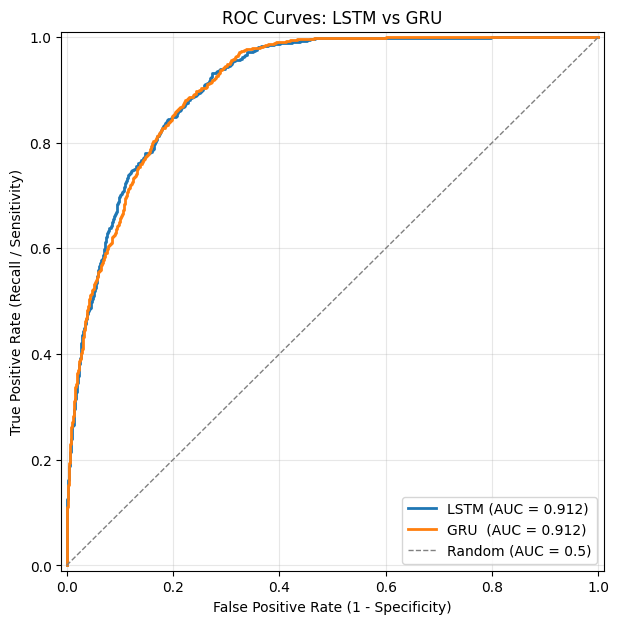

In [35]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1) Get predicted probabilities
y_prob_LSTM = model_LSTM.predict([Xseq_te_s, Xs_te_s]).ravel()
y_prob_GRU  = model_GRU.predict([Xseq_te_s, Xs_te_s]).ravel()

# 2) Compute ROC curve and AUC for both models
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_LSTM)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test, y_prob_GRU)
roc_auc_gru = auc(fpr_gru, tpr_gru)

print(f"LSTM ROC AUC = {roc_auc_lstm:.4f}")
print(f"GRU  ROC AUC = {roc_auc_gru:.4f}")

# 3) Plot both ROC curves
plt.figure(figsize=(7,7))
plt.plot(fpr_lstm, tpr_lstm, lw=2, label=f"LSTM (AUC = {roc_auc_lstm:.3f})")
plt.plot(fpr_gru,  tpr_gru,  lw=2, label=f"GRU  (AUC = {roc_auc_gru:.3f})")

# Reference line for random classifier
plt.plot([0,1], [0,1], color="gray", linestyle="--", lw=1, label="Random (AUC = 0.5)")

# Formatting
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curves: LSTM vs GRU")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
